In [6]:
import numpy as np
import pandas as pd
import scipy.signal
import PIL.Image as Image
import matplotlib.pyplot as plt

In [7]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [8]:
IMAGE_SIZE = (28, 28)

# Import data
data = pd.read_csv(r"../digit-recognizer/train.csv")
data_test = pd.read_csv(r"../digit-recognizer/test.csv")

# Get labels and image array from data
# Only 30000 data used. The rest were used for testing (with labels, to check the accuracy)
labels : np.ndarray = data.values[:30000, 0]
images : np.ndarray = data.values[:30000, 1:].astype('uint8').reshape((-1, 1) + IMAGE_SIZE) / 255

images_test : np.ndarray = data_test.values.astype('uint8') / 255

images_test_with_label = data.values[30000:, 1:].astype('uint8') / 255
labels_test_with_label = data.values[30000:, 0]

In [61]:
class Layer:
    def __init__(self, name):
        self.name = name

class Convolutional2DLayer(Layer):
    def __init__(self, name, in_channel: int, out_channel: int, input_shape: tuple, kernel_size: int, stride: int = 1, padding: int = 0):
        """Convolution layer of CNN. Receives: 
            in_channel -> amount of channels the input has
            out_channel -> amount of channels the output has
            input_shape -> input shape (without the channels)
            kernel_size -> kernel size used for convolution
            stride -> how many cells kernel will move
            padding -> amount of zero padding
        """
        super().__init__(name)
        self.kernels: np.ndarray = np.random.normal(size=(in_channel, out_channel, kernel_size, kernel_size))
        self.stride: int = stride
        self.padding: int = padding
        self.input_shape: tuple = (in_channel,) + input_shape
        self.out_shape: tuple = (out_channel, ) + tuple(np.add(np.add(np.subtract(input_shape, kernel_size), 2*padding) // stride, 1))

        self.gradient = np.zeros(self.input_shape)

    def _convolve(self, x: np.ndarray, kernel: np.ndarray, out_shape: tuple, padding: int = None, stride: int = None, mode: str = "VALID"):
        """Convolution process"""
        # assert (type(x) == np.ndarray), f"Error: x must be a numpy array"
        if (padding == None):
            padding = self.padding
        if (stride == None):
            stride = self.stride
        if (mode == "FULL"):
            x = np.pad(x, kernel.shape[0]-1)

        x = np.pad(x, padding)
        res = np.zeros(out_shape)

        for i in range(0, res.shape[0], stride):
            for j in range(0, res.shape[1], stride):
                for k in range(0, kernel.shape[0]):
                    for l in range(0, kernel.shape[1]):
                        res[i][j] += x[i+k][j+l] * kernel[k][l]

        return res

    def backward(self, grad, lr):
        # out = (5, 10, 3, 3)
        # input = (5, 13, 13)
        # grad = (10, 11, 11)
        grad = grad.reshape(grad.shape[:-1])
        kernel_grad = np.zeros(self.kernels.shape) # (5, 10, 3, 3)
        for i in range(self.gradient.shape[0]):
            for g in range(grad.shape[0]):
                kernel_grad[i][g] = self._convolve(self.gradient[i], grad[g], self.kernels.shape[2:])

        # out = (5, 13, 13)
        # grad = (10, 11, 11)
        # kernel = (5, 10, 3, 3)
        input_grad = np.zeros(self.input_shape) # (5, 13, 13)
        for c in range(self.kernels.shape[0]): # for each input channel (5)
            for k in range(self.kernels.shape[1]): # for each 3x3 kernel (10)
                input_grad[c] += self._convolve(grad[k], np.rot90(np.rot90(self.kernels[c][k])), self.input_shape[1:], mode="FULL")

        self.kernels -= np.array(kernel_grad) * lr
        self.gradient = 0
        return np.array(input_grad).reshape(input_grad.shape + (1,))

    def __call__(self, x: np.ndarray):
        """Forward method"""    

        assert (type(x) == np.ndarray), f"Error: x must be a numpy array"
        assert (x.shape == self.input_shape), f"Error: layer {self.__class__.__name__}accepts {self.input_shape} input, while x is shaped as {x.shape}"
        self.gradient += x
        output = np.zeros(self.out_shape, dtype=np.float64)
        
        # print(x.shape, self.kernels.shape)
        for c, in_channel in enumerate(self.kernels): # 5 in_channel
            for k, kernel in enumerate(in_channel): # 10 kernels
                output[k] += self._convolve(x[c], kernel, self.out_shape[1:])

        return output

class MaxPooling2d(Layer):
    def __init__(self, name, input_shape: tuple, kernel_size: int, stride: int=1, padding: int=0):
        """2 dimensional max pooling"""
        assert (len(input_shape) == 3), f"Error: 2D max pooling layer's input shape must be in (channel, row, height) format. Input is {input_shape}"
        super().__init__(name)
        self.input_shape: tuple = input_shape
        self.kernel_size: int = kernel_size
        self.stride: int = stride
        self.padding: int = padding    
        self.out_shape: tuple = (input_shape[0], ) + tuple(np.add(np.add(np.subtract(input_shape[1:], kernel_size), 2*padding) // stride, 1))
        self.gradient: np.ndarray = np.zeros(self.input_shape)
    
    def backward(self, grad, lr):
        grad = grad.reshape(grad.shape[:-1])

        for c in range(self.gradient.shape[0]):
            k = l = 0
            for i in range(self.gradient.shape[1]):
                for j in range(self.gradient.shape[2]):
                    if (self.gradient[c][i][j] == 1):
                        # print(self.gradient)
                        self.gradient[c][i][j] = grad[c][k][l]
                        l += 1
                        if (l >= self.gradient.shape[-1]):
                            l = 0
                            k += 1

        grad = self.gradient.copy()
        self.gradient = 0

        # print(f"This: {grad}")
        return grad

    def __call__(self, x: np.ndarray):
        """2 dimensional max pooling"""

        assert (type(x) == np.ndarray), f"Error: x must be a numpy array"
        assert (x.shape == self.input_shape), f"Error: this layer accepts {self.input_shape} input, while x is shaped as {x.shape}"
        # print(x.shape[0])
        # print((np.subtract(x.shape[1:], kernel_size) // stride))
        output = np.full(self.out_shape, 0, dtype=np.float64)    
        grad = np.full(self.input_shape, 0, dtype=np.float64)
        for c in range(output.shape[0]):
            for i in range(0, output.shape[1], self.stride):
                for j in range(0, output.shape[2], self.stride):
                    maxk = maxl = -1
                    for k in range(self.kernel_size):
                        for l in range(self.kernel_size):
                            if (x[c][i+k][j+l] > output[c][i][j]):
                                output[c][i][j] = x[c][i+k][j+l]
                                maxk = k
                                maxl = l
                                
                    if (maxk != -1 and maxl != -1):
                        grad[c][i+maxk][j+maxl] = 1 
                            
        self.gradient += grad

        return output

class LinearLayer(Layer):
    def __init__(self, name, input, output):
        super().__init__(name)
        self.weight = np.random.normal(size=(input, output))
        self.bias = np.zeros(output)
        self.gradient: np.ndarray = np.zeros(input)

    def backward(self, grad, lr):
        newgrad = np.dot(self.weight, grad) 
        self.weight -= np.outer(self.gradient, grad) * lr
        self.bias -= grad.reshape(grad.shape[0]) * lr
        self.gradient = 0
        return newgrad

    def __call__(self, x: np.ndarray):
        assert (type(x) == np.ndarray), f"Error: x must be a numpy array"
        assert (x.shape[0] == self.weight.shape[0]), f"Error: this layer accepts (n, {self.weight.shape[0]}) input, while x is shaped as {x.shape}"

        self.gradient += x
        output = np.dot(x, self.weight)
        output += self.bias
        return output

class Relu(Layer):
    def __init__(self, name):
        super().__init__(name)
    
    def backward(self, grad, lr=None):
        # if (grad.shape == (10, 1)):

        grad = grad * self.gradient
        # print(grad, self.gradient)
        self.gradient = 0
        return grad

    def __call__(self, x: np.ndarray):
        self.gradient = (x > 0).astype(np.float64).reshape(x.shape + (1,))        
        return np.maximum(0, x)

class LeakyRelu(Layer):
    def __init__(self, name):
        super().__init__(name)
    
    def backward(self, grad, lr=None):
        # if (grad.shape == (10, 1)):

        grad = grad * self.gradient
        # print(grad, self.gradient)
        self.gradient = 0
        return grad

    def __call__(self, x: np.ndarray):
        self.gradient = np.where(x < 0, 0.01, 1).reshape(x.shape + (1,))
        return np.maximum(0.01, x)


class Flatten(Layer):
    def __init__(self, name, input_shape):
        super().__init__(name)
        self.input_shape = input_shape
        
    def __call__(self, x):
        return x.reshape((-1))

    def backward(self, grad, lr):
        return grad.reshape(self.input_shape + (1,))
    
def get_flatten_shape(shape: tuple):
    return int(np.prod(np.array(shape)))

def softmax(x: np.ndarray):
    exps = np.exp(x - x.max())
    return np.clip(exps / np.sum(exps), 1e-7, 1)

x = np.array([-1, -2, 1, 2, 3, 0])
print(x > 0)
    

[False False  True  True  True False]


In [10]:
class NN:
    def __init__(self):
        self.layers : Layer = []
        self.gradient = 0

    def check_weight(self):
        old_weight = []
        for layer in self.layers:
            if (hasattr(layer, "weights")):
                old_weight.append(layer.weights)
#                 print(layer.weights)
            if (hasattr(layer, "kernels")):
                old_weight.append(layer.kernels)
#                 print(layer.kernels)

        return old_weight

    def forward(self, x):
        # print()
        for layer in self.layers:
            # print(f"Input: {x}")
            x = layer(x)
            
            # if (hasattr(layer, "out_shape")):
            #     print(layer.out_shape)
            # # if hasattr(layer, "gradient"):
            # #     print("Grad: ", layer.gradient.shape)
            # # if hasattr(layer, "kernels"):
            # #     print("Kernel: ", layer.kernels.shape)
            # if hasattr(layer, "weight"):
            #     print("Weight: ", layer.weight.shape)

        return x

    def backward(self, lr):
        for layer in reversed(self.layers):
            # print(layer.name, "=", self.gradient.shape)
            self.gradient = layer.backward(self.gradient, lr)

        self.gradient = 0
        
    def cross_entropy_loss(self, pred, label):
        pred = softmax(pred)

        d_pred = []
        for i in range(len(pred)):
            if i == label:
                d_pred.append(pred[label] * (1-pred[i]))
            else:
                d_pred.append(-pred[label] * pred[i])
        
        self.gradient = np.outer(d_pred, -1 / pred[label])

        return -np.log(pred[label])    

In [11]:
class CNN(NN):
    def __init__(self):
        conv1 = Convolutional2DLayer("conv1", 1, 5, IMAGE_SIZE, kernel_size=3)            
        # maxpool1 = MaxPooling2d("maxpool1", conv1.out_shape, 2, stride=2)
        relu1 = Relu("relu1")
        conv2 = Convolutional2DLayer("conv2", conv1.out_shape[0], 10, conv1.out_shape[1:], kernel_size=3)
        # maxpool2 = MaxPooling2d("maxpool2", conv2.out_shape, 2, stride=2)
        relu2 = Relu("relu2")
        flatten = Flatten("flatten", conv2.out_shape)
        linear1 = LinearLayer("linear1", get_flatten_shape(conv2.out_shape), 256)
        relu3 = Relu("relu3")
        linear2 = LinearLayer("linear2", 256, 10)
        relu4 = Relu("relu4")
        # print(conv1.out_shape)
        # print(maxpool1.out_shape)
        # print(conv2.out_shape)
        # print(maxpool2.out_shape)

        self.layers = [
            conv1, conv2, flatten, linear1, linear2   
        ]

        self.gradient = 0

# maxpool3 = MaxPooling2d((1, 2, 2), 2)
# print(maxpool3(np.array([[[1, 2], [3, 4]]])))

# print(linear1.gradient)

Data 99, Loss: 16.11809565095832
Label: 5. Prediction: [  5986.45190617   1051.23263363 -13447.36348481  -3310.08996431
   7907.64343272   1305.02105949  -4771.56195396  -3111.43097194
 -24099.31587979 -12409.71228742]
Data 199, Loss: 16.11809565095832
Label: 2. Prediction: [-12188.5555571   -4196.42911189  -1016.63917754 -10054.33531486
   3136.78455237     45.8882037     342.94664966    773.79731204
   6883.01602406   8310.30681366]
Data 299, Loss: 16.11809565095832
Label: 4. Prediction: [ -2707.62490962   5949.51518115 -10404.26281018   4528.61953232
    916.13767412   1393.53348413     75.54973735  -1363.78602112
  11118.38683862   4929.41762614]
Data 399, Loss: 16.11809565095832
Label: 6. Prediction: [   970.66762701 -11612.61675396   7206.1769127   -5997.18422076
  -2707.54971593   -140.52410644    -84.52119737   2302.60213699
   2458.40440535   4616.58143922]
Data 499, Loss: 16.11809565095832
Label: 9. Prediction: [-1980.76900826 -9781.56462574   437.90402489 -7244.19123472
 -57

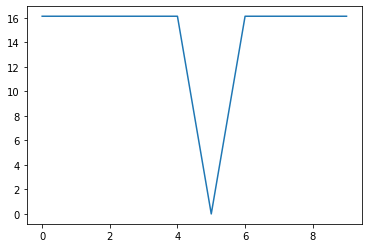

In [59]:
cnn = CNN()
LEARNING_RATE = 0.000001
loss_all = []

old_weight = []
for i, image in enumerate(images[:1000]):
    res = cnn.forward(image)
    loss = cnn.cross_entropy_loss(res, labels[i])
    cnn.backward(LEARNING_RATE)
    if ((i+1) % 100 == 0):
        loss_all.append(loss)
        print(f"Data {i+1}, Loss: {loss}")
        print(f"Label: {labels[i]}. Prediction: {res}")
#         print(cnn.check_weight())

plt.plot(loss_all)

In [60]:
d = images[101]

d1 = cnn.layers[0](d)
for c in d1:
    img = Image.fromarray(c.astype(np.uint8))
    img.show()

In [44]:
class NNTest(NN):
    def __init__(self):
        linear1 = LinearLayer("linear1", IMAGE_SIZE[0] * IMAGE_SIZE[1], 512)
        relu1 = Relu("relu1")
        linear2 = LinearLayer("linear2", 512, 10)
        relu2 = Relu("relu2")

        lrelu1 = LeakyRelu("lrelu1")

        self.layers = [linear1, lrelu1, linear2]

# Train - Normal Neural Network

Data 2000 --> Correct: 1492. Accuracy: 74.6%
Label: 4. Prediction: [-345.27166583  -27.06014266 -381.73675912  -80.27168735  362.48123582
   61.59213224  -56.54260548  237.59825786   64.28722106   55.15735262]
Data 4000 --> Correct: 3210. Accuracy: 80.25%
Label: 4. Prediction: [-117.92515272   24.78264929  -23.26326048    1.93910881  258.99753639
  -43.34574867  197.64801553  -19.69691195  -14.47534991   24.34934148]
Data 6000 --> Correct: 4954. Accuracy: 82.56666666666666%
Label: 0. Prediction: [ 340.08710986 -164.9704144    48.93091824   -6.86561647 -184.73145634
  -80.84228675 -101.19890087  -74.5224986   -84.6098377   -47.82981931]
Data 8000 --> Correct: 6706. Accuracy: 83.825%
Label: 3. Prediction: [-143.45194682  -29.22537018   59.82617578  250.13262036  -89.75502463
  -21.85797013  -91.92423599  -30.05610274   35.4884669   -31.74064584]
Data 10000 --> Correct: 8487. Accuracy: 84.87%
Label: 9. Prediction: [ -74.19830136  -32.54496338 -106.72063744   64.85281906   50.31943369
   3

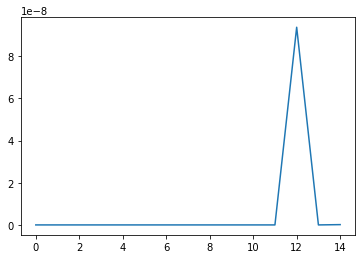

Data 2000 --> Correct: 1870. Accuracy: 93.5%
Label: 4. Prediction: [-33.05734108 -56.63118802 -25.61155454   6.02825015 103.0441637
  -7.49031583  12.54554372   5.69650285  24.44241052  48.89684166]
Data 4000 --> Correct: 3756. Accuracy: 93.89999999999999%
Label: 4. Prediction: [ 13.50974069 -28.57251515  12.44589166 -13.38739401  74.91571943
   3.37058681   1.01712825 -12.79721686   6.91570723  19.4317484 ]
Data 6000 --> Correct: 5631. Accuracy: 93.85%
Label: 0. Prediction: [ 1.44579357e+02 -9.39317465e+01 -9.80689674e+00 -2.43919749e+01
 -6.44552155e+01 -5.74894586e+01 -7.61993668e+01 -1.28231717e-01
 -4.41304498e+01 -1.02413720e+01]
Data 8000 --> Correct: 7504. Accuracy: 93.8%
Label: 3. Prediction: [-92.75538719 -27.83299994   4.88579355 108.13899573 -66.52172982
   9.94046569 -48.15753889 -19.08051536 -30.9474888   -2.77364725]
Data 10000 --> Correct: 9394. Accuracy: 93.94%
Label: 9. Prediction: [-24.14773803 -30.55893152 -15.89240252  68.79007984  10.91297121
  44.62786652 -42.754

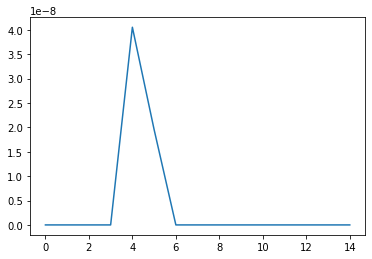

Data 2000 --> Correct: 1933. Accuracy: 96.65%
Label: 4. Prediction: [-46.50325668 -58.90894518 -35.30657959   1.35226682  87.03857931
 -32.74575646  -3.29099536   8.00959069  26.54973478  43.06459561]
Data 4000 --> Correct: 3858. Accuracy: 96.45%
Label: 4. Prediction: [ -3.98518723 -12.51293665  -4.41468477   3.25383397  48.14903417
 -10.9236319  -12.5978992    3.206251     6.61894755  26.04871826]
Data 6000 --> Correct: 5790. Accuracy: 96.5%
Label: 0. Prediction: [ 126.14250116 -100.94309402  -14.11922109  -16.72342499  -49.79842174
  -27.0933503   -50.99216572   10.03677102  -12.30528967  -17.58828168]
Data 8000 --> Correct: 7712. Accuracy: 96.39999999999999%
Label: 3. Prediction: [-63.23567482 -21.90990518   6.82127407  95.71635641 -78.67432793
  13.00839883 -56.70789134 -21.91027439 -32.22649009 -22.43585089]
Data 10000 --> Correct: 9635. Accuracy: 96.35000000000001%
Label: 9. Prediction: [-15.23031408 -37.29451788  -4.45316558  57.94210938   1.35423272
  34.49810561 -36.27864792  

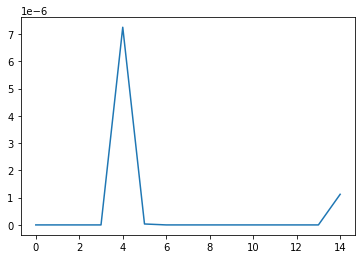

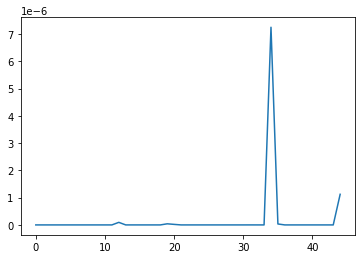

In [47]:
nn = NNTest()
loss_all = []
EPOCH = 3
for e in range(EPOCH):
    correct = 0
    loss_epoch = []
    for i, image in enumerate(images):
        res = nn.forward(image.reshape(IMAGE_SIZE[0] * IMAGE_SIZE[1]))
        # print(res)
        loss = nn.cross_entropy_loss(res, labels[i])
        nn.backward(0.01)
        if (res.argmax() == labels[i]): correct += 1
        
        if ((i+1) % 2000 == 0):
            print(f"Data {i+1} --> Correct: {correct}. Accuracy: {correct / (i+1) * 100}%")
            print(f"Label: {labels[i]}. Prediction: {res}")
            loss_epoch.append(loss)

    print(f"Epoch {e} --> Correct: {correct}. Accuracy: {correct / len(images) * 100}%")

    loss_all += loss_epoch
    plt.plot(loss_epoch)
    plt.show()

plt.plot(loss_all)
plt.show()

# Test - Normal Neural Network

In [ ]:
correct = 0
for i, image in enumerate(images_test_with_label):
    if (nn.forward(image).argmax() == labels_test_with_label[i]):
        correct += 1

print(f"Test result --> Correct: {correct}. Accuracy: {correct / len(images_test_with_label) * 100}%")

Test result --> Correct: 1198. Accuracy: 9.983333333333333%


In [ ]:
class XORNN(NN):
    def __init__(self):
        linear1 = LinearLayer("linear1", 3, 512)
        relu1 = Relu("relu1")
        linear2 = LinearLayer("linear2", 512, 256)
        relu2 = Relu("relu2")
        linear4 = LinearLayer("linear2", 256, 2)


        self.layers = [linear1, linear2, linear4]


xor = np.array([
    [1, 1, 1],
    [1, 0, 0],
    [0, 0, 0],
    [0, 0, 1],
    [1, 0, 1],
    [1, 1, 0],
])

label = np.array([0, 1, 0, 1, 1, 1])
model = XORNN()

for e in range(100000):
    correct = 0
    for i, d in enumerate(xor):
        res = model.forward(d)
        # print(res)
        loss = model.cross_entropy_loss(res, label[i])
        model.backward(0.1)
        if (res.argmax() == label[i]): correct += 1

        # if ((i+1) % 1 == 0):
        #     print(f"Data {i+1} --> Correct: {correct}. Accuracy: {correct / (i+1) * 100}%")


    if (e % 1000 == 0):
        print(f"Epoch {e} --> Correct: {correct}. Accuracy: {correct / len(xor) * 100}%")

        loss_all.append(loss)

plt.plot(loss_all)
plt.show()
    

Epoch 0 --> Correct: 4. Accuracy: 66.66666666666666%


KeyboardInterrupt: 

In [ ]:
print(model.forward(np.array([0, 1, 0])))

[nan nan]


In [36]:
relu = Relu("Test")

y = np.array([1, -2, -3, 1, 3, 4, -3, 0])
relu(y)
g = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(relu.gradient.shape)
print(g)
print(relu.gradient)
print(relu.backward(g, 0.0001))

[[1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]]
[[1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]
[[1.]
 [0.]
 [0.]
 [4.]
 [5.]
 [6.]
 [0.]
 [0.]]


In [65]:
maxpool = MaxPooling2d("maxpool", (1, 4, 4), 2, 2)
x = np.array([
    [
        [1, 2, 3, 4],
        [4, 3, 2, 1],
        [100, 1, 2, 3],
        [6, 7, 8, 9]
    ]
])

print(maxpool(x))

[[[  4.   0.]
  [100.   0.]]]
